<a href="#section1">1. Data/Variables preprocessing</a>

<a href="#section2">2. Image Visualization (RGB Bands) </a><br>
<a href="#section2.1" style="margin-left:20px">2.1. Full Image (26159x796) </a><br>
<a href="#section2.2" style="margin-left:20px">2.2. ROI (285x76) </a><br>
<a href="#section2.3" style="margin-left:20px">2.3. Ground Truth (285x76) </a><br>

<a href="#section3">3. Linear Matched Filter Detector (MFD) </a><br>
<a href="#section3.1" style="margin-left:20px">3.1. Data/Variables preprocessing</a><br>
<a href="#section3.2" style="margin-left:20px">3.2. MFD Model Prediction</a>

<a href="#section4">4. Kernel Spectral Matched Filter (KSMF) </a><br>
<a href="#section4.1" style="margin-left:20px">4.1. Data/Variables preprocessing</a><br>
<a href="#section4.2" style="margin-left:20px">4.2. Gaussian Kernel Model Prediction</a><br>
<a href="#section4.3" style="margin-left:20px">4.3. Polynomial Kernel Model Prediction</a><br>
<a href="#section4.4" style="margin-left:20px">4.4. Spectral Angle Kernel Model Prediction</a>

<a href="#section5">5. ROC curve </a><br>

   I am going to implement the paper - "Kernel Spectral Matched Filter for Hyperspectral Imagery"

https://link.springer.com/article/10.1007/s11263-006-6689-3
### we implement & check variation of eqn 7 (MFD), eqn 27 (KSMF) with some background clustering tricks

In [1]:
import spectral.io.envi as envi
from spectral import *
import numpy as np
from sklearn.cluster import KMeans
import random
import copy
from sklearn.cluster import KMeans
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve

<a id="section1"></a>
# 1. Data/Variables preprocessing

In [17]:
# read hdr specs file and hdr file
img = envi.open('./data/Reflect_f100517out.hdr', './data/Reflect_f100517out')
print(img.shape)

# for KSMF kernel we can try arbitrary number of clusters/centroids for background pixels for different data
# used for implementation of a variant of eqn 27 of KSMF as given in paper for K^ ^ R^ calculation
num_clusters_KSMF = 200 # it can be anything but generally something between 200-300 works best

# as eqn 7 of paper didn't work well, so I tried something dfferent for covariance/correlation matrix
# for MFD keep num_clusters same as number of spectral bands 
# for dot product & matrix multiplication shape matching in Line 12 sec 3.2 below for y calculation (eqn 7)
num_clusters_MFD = 224 # because our hdr file has 224 spectral bands

# wavelength: Red ~ 669, Green ~ 549, Blue ~ 474 
# selected resp. spectral band index from hdr file (Reflect_f100517out.hdr) with closest wavelength matching
rgb_bands = (32, 20, 12)

# an orange pixel (oil spill) which is considered target pixel
# an orange pixel is selected at spatial index [11461, 353, :] from Full Image - RGB Channels (sec 2.1) below
target_spectrum = img[11461, 353, :].reshape(1, -1) # shape [1, 224] 224 spectral bands


# Manually selected an ROI around the ornage target pixel
ROI = img[11420:11496,100:385, :] # bigger ROI with one ship too
# ROI = img[11430:11485,300:385, :] # using smaller ROI for faster marix inversion later
print("ROI Shape:", ROI.shape)


# Ground truth - same spatial dimensions as ROI but only 3 spectral channels/bands for RGB visualization
GT_RGB = np.zeros((ROI.shape[0], ROI.shape[1], 3)) # initialize with black pixels
for i in range(GT_RGB.shape[0]):
    for j in range(GT_RGB.shape[1]):
        pixel_spectrum = ROI[i,j,:].reshape(1, -1)
        
        # e.g. current pixel's spectrum values euclidean distance from target_spectrum
        taregt_pixel_distance = np.sqrt(np.sum(target_spectrum - pixel_spectrum)**2)
        
        if taregt_pixel_distance <= 5: # can try other values
            GT_RGB[i,j,:] = 1 # white 

print("GT_RGB  Shape:", GT_RGB.shape)        

(26159, 796, 224)
ROI Shape: (76, 285, 224)
GT_RGB  Shape: (76, 285, 3)


<a id="section2"></a>
# 2. Image Visualization (RGB Spectral Bands)

<a id="section2.1"></a>
## 2.1. Full Image - RGB Channels (26159 x 796)

In [4]:
# read the rgb bands of image for visualization
img_rgb = img[:,:,rgb_bands]
print(img_rgb.shape)

# image size too big to be visualized here, so save for visualization separately
full_img = np.rint(img_rgb*255) # round off, integers between 0 - 255
full_img = Image.fromarray(full_img.astype(np.uint8))
full_img.save("./pics/Full_img_RGB_Bands_" + str(rgb_bands) + ".png")

(26159, 796, 3)


<a id="section2.2"></a>
## 2.2. ROI - RGB Channels (285 x 76)

ROI_RGB Shape: (76, 285, 3)


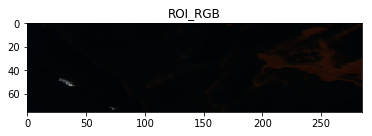

In [3]:
ROI_RGB = ROI[:, :, rgb_bands]
print("ROI_RGB Shape:", ROI_RGB.shape)

plt.imshow(ROI_RGB)
plt.title("ROI_RGB")
plt.savefig("./pics/ROI_RGB.png")

<a id="section2.3"></a>
## 2.3. Ground Truth - RGB Channels (285 x 76)

GT_RGB Shape: (76, 285, 3)


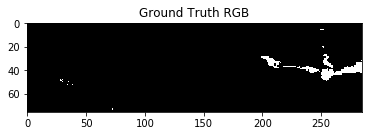

In [4]:
print("GT_RGB Shape:", GT_RGB.shape)

plt.imshow(GT_RGB)
plt.title("Ground Truth RGB")
plt.savefig("./pics/GT_RGB.png")

<a id="section3"></a>
# 3. MFD

<a id="section3.1"></a>
## 3.1. Data/Variables Pre-processing

In [6]:
# read the (285*76=21660 pixels)
X = []
for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        X.append(ROI[i,j,:])

# shape should be [21660 pixels, 224 spectral bands] or [ROI.shape[0]*ROI.shape[1], ROI.shape[2]]
X = np.array(X) # eqn 2 in paper
print("X Shape:", X.shape)

### using R_hat_inv didn't gave good results so using the inv_covariance_background method below 
# X = X.T         # shape [j, N] where j is number of spectral bands, N is total number of spatial pixels
# R_hat = X.dot(X.T)
# R_hat /= X.shape[1] # R_hat = (1/N)*X*X.T
# print("R_hat Shape:", R_hat.shape)
# R_hat_inv = np.linalg.pinv(R_hat)
# print("R_hat_inv Shape:", R_hat_inv.shape)
###

# k_means clustering of background pixels
background_pixels = []
for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i, j, :].reshape(-1,1)
        
        # eucleadean distance betwwen current spectral band and taregt spectrum band of the orange pixel
        target_distance = np.sqrt(np.sum(current_pixel_spectrum - target_spectrum)**2)
        
        if target_distance > 5: # we used threshold of 5 in sec 1
            background_pixels.append(current_pixel_spectrum)

background_pixels = np.array(background_pixels)
background_pixels = background_pixels.reshape(background_pixels.shape[0], background_pixels.shape[1])
print("Background Pixels Shape:", background_pixels.shape)

kmeans = KMeans(n_clusters=num_clusters_MFD, random_state=0).fit(background_pixels)
centroids = kmeans.cluster_centers_
print("Centroids Shape:", centroids.shape)

mean_background = np.mean(centroids, axis=0)
mean_background = mean_background.reshape(1,-1)
print("Mean Background Shape:", mean_background.shape)

covariance_background = np.cov(centroids)
print("Background Covariance Shape:", covariance_background.shape)

# use pseudo inverse if normal inverse matrix doesn't exist
inv_covariance_background = np.linalg.inv(covariance_background) # normal matrix inverse
# inv_covariance_background = np.linalg.pinv(covariance_background) # pesudo inverse

print("Background Covariance Inverse Shape:", inv_covariance_background.shape)

X Shape: (21660, 224)
Background Pixels Shape: (21655, 224)
Centroids Shape: (224, 224)
Mean Background Shape: (1, 224)
Background Covariance Shape: (224, 224)
Background Covariance Inverse Shape: (224, 224)


<a id="section3.2"></a>
## 3.2. MFD Model Prediction

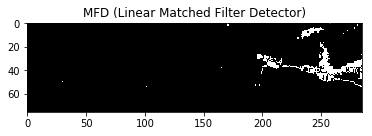

In [7]:
predictions_MFD = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_MFD = []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:].reshape(1, -1)
        
        x1 = target_spectrum - mean_background
        x2 = current_pixel_spectrum - mean_background
        
#         y = (((x1).dot(R_hat_inv)).dot(x2.T))/(((x1).dot(R_hat_inv)).dot(x1.T)) # eqn 7 of paper
        y = (((x1).dot(inv_covariance_background)).dot(x2.T))/(((x1).dot(inv_covariance_background)).dot(x1.T))
        
        y = y[0][0] # y is an array so extract value
        
        y_MFD.append(y)
        
        if y > .8: # using this threshold value (.8) after trying various other values
            predictions_MFD[i,j,:] = 1
            
plt.imshow(predictions_MFD)
plt.title("MFD (Linear Matched Filter Detector)")
plt.savefig("./pics/MFD.png")

<a id="section4"></a>
# 4. KSMF

<a id="section4.1"></a>
## 4.1. Data/Variables Pre-processing

In [18]:
# read the (285*76=21660 pixels)
X = []
for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        X.append(ROI[i,j,:])       
# shape should be [21660 pixels, 224 spectral bands] or [ROI.shape[0]*ROI.shape[1], ROI.shape[2]]
X = np.array(X) # eqn 2 in paper
print("X Shape:", X.shape)

# k_means clustering of background pixels
background_pixels = []
for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i, j, :].reshape(-1,1)
        
        # eucleadean distance betwwen current spectral band and taregt spectrum band of the orange pixel
        target_distance = np.sqrt(np.sum(current_pixel_spectrum - target_spectrum)**2)
        
        if target_distance > 5: # we used threshold of 5 in sec 1
            background_pixels.append(current_pixel_spectrum)

background_pixels = np.array(background_pixels)
background_pixels = background_pixels.reshape(background_pixels.shape[0], background_pixels.shape[1])
print("Background Pixels Shape:", background_pixels.shape)

kmeans = KMeans(n_clusters=num_clusters_KSMF, random_state=0).fit(background_pixels)
centroids = kmeans.cluster_centers_
print("Centroids Shape:", centroids.shape)

X Shape: (21660, 224)
Background Pixels Shape: (21655, 224)
Centroids Shape: (200, 224)


<a id="section4.2"></a>
## 4.2. KSMF - Gaussian Kernel

Kernel Matrix Shape: (200, 200)
K_inv2 Shape (200, 200)
k_s Shape: (1, 200)


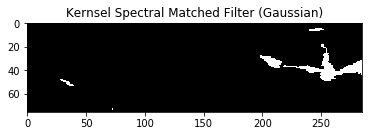

In [19]:
c= 30 # width of Gaussian RBF kernel, to be determined

#Gaussian_Radial Basis Function (GRBF)
def k_GRBF(x, y):                     
    norm= np.linalg.norm(x - y)
    return np.exp(-1*norm*norm/c)

# Kernel/Gram Matrix
K = np.zeros((centroids.shape[0], centroids.shape[0])) # K(X,X) the gram matrix
for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        K[i,j] = k_GRBF(centroids[i,:].reshape(1,-1), centroids[j,:].reshape(1,-1))
print("Kernel Matrix Shape:", K.shape)

K_inv = np.linalg.pinv(K) # calculating pseudo inverse as normal inverse gave errors
K_inv2 = K_inv**2 # K^-2 that's to be used in eqn 27 of paper
print("K_inv2 Shape", K_inv2.shape)

# function to calculate k_s or k_r or function (psi(s)*X.T) or (psi(r)*X.T) in eqn 24 & eqn 25 of [a[er]]
def ks_kr(spectrum_value):
    k = []
    for i in range(centroids.shape[0]):
        k_ = k_GRBF(spectrum_value, centroids[i].reshape(1,-1))
        k.append(k_)
    
    k = np.array(k).reshape(1,-1)
    return k

k_s = ks_kr(target_spectrum) # eqn 24
print("k_s Shape:", k_s.shape)

# get the predictions. keeping it in RGB channel format for easy visulatization as Ground Truth RGB file
predictions_gaussian = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_gaussian = []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:].reshape(1, -1)
        k_r = ks_kr(ROI[i,j,:].reshape(1, -1)) # eqn 25 of paper
        
        y = ((k_s.dot(K_inv2)).dot(k_r.T))/((k_s.dot(K_inv2)).dot(k_s.T))       
        y = y[0][0]
        
        y_gaussian.append(y)

        if y <= 1.2 :  # using this threshold value (1.2) after trying various other values
            predictions_gaussian[i,j,:] = 1
            
plt.imshow(predictions_gaussian)
plt.title("Kernsel Spectral Matched Filter (Gaussian)")
plt.savefig("./pics/KSMF_Gaussian.png")

<a id="section4.3"></a>
## 4.3. KSMF - Polynomial Kernel

Kernel Matrix Shape: (200, 200)
K_inv2 Shape (200, 200)
k_s Shape: (1, 200)


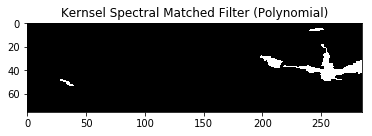

In [20]:
d= 5 #power parameter of polynomial kernel, tbd
theta= 1 #constant term for polynomial kernel, tbd

#Polynomial Kernel.
def k_poly(x,y):                        
    return np.power(np.dot(x,y.T)+theta, d)

# Kernel/Gram Matrix
K = np.zeros((centroids.shape[0], centroids.shape[0])) # K(X,X) the gram matrix
for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        K[i,j] = k_poly(centroids[i,:].reshape(1,-1), centroids[j,:].reshape(1,-1))
print("Kernel Matrix Shape:", K.shape)

K_inv = np.linalg.pinv(K) # calculating pseudo inverse as normal inverse gave errors
K_inv2 = K_inv**2 # K^-2 that's to be used in eqn 27 of paper
print("K_inv2 Shape", K_inv2.shape)

# function to calculate k_s or k_r or function (psi(s)*X.T) or (psi(r)*X.T) in eqn 24 & eqn 25 of [a[er]]
def ks_kr(spectrum_value):
    k = []
    for i in range(centroids.shape[0]):
        k_ = k_poly(spectrum_value, centroids[i].reshape(1,-1))
        k.append(k_)
    
    k = np.array(k).reshape(1,-1)
    return k

k_s = ks_kr(target_spectrum) # eqn 24
print("k_s Shape:", k_s.shape)

# get the predictions. keeping it in RGB channel format for easy visulatization as Ground Truth RGB file
predictions_poly = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_poly = []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:].reshape(1, -1)
        k_r = ks_kr(ROI[i,j,:].reshape(1, -1)) # eqn 25 of paper
        
        y = ((k_s.dot(K_inv2)).dot(k_r.T))/((k_s.dot(K_inv2)).dot(k_s.T))       
        y = y[0][0]
        
        y_poly.append(y)
        
        if y > .5 : # using this threshold value (.5) after trying various other values
            predictions_poly[i,j,:] = 1
            
plt.imshow(predictions_poly)
plt.title("Kernsel Spectral Matched Filter (Polynomial)")
plt.savefig("./pics/KSMF_Polynomial.png")

<a id="section4.4"></a>
## 4.4. KSMF - Spectral Angle Kernel

Kernel Matrix Shape: (200, 200)
K_inv2 Shape (200, 200)
k_s Shape: (1, 200)


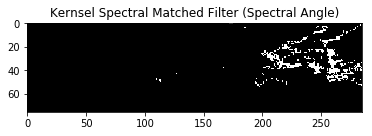

In [21]:
#Spectral angle_based kernel.
def k_spectral_angle_based(x, y):        
    norm_x= np.linalg.norm(x)
    norm_y= np.linalg.norm(y)
    dot= x.dot(y.T)
    return dot/(norm_x*norm_y)


# Kernel/Gram Matrix
K = np.zeros((centroids.shape[0], centroids.shape[0])) # K(X,X) the gram matrix
for i in range(K.shape[0]):
    for j in range(K.shape[1]):
        K[i,j] = k_spectral_angle_based(centroids[i,:].reshape(1,-1), centroids[j,:].reshape(1,-1))
print("Kernel Matrix Shape:", K.shape)

K_inv = np.linalg.pinv(K) # calculating pseudo inverse as normal inverse gave errors
K_inv2 = K_inv**2 # K^-2 that's to be used in eqn 27 of paper
print("K_inv2 Shape", K_inv2.shape)

# function to calculate k_s or k_r or function (psi(s)*X.T) or (psi(r)*X.T) in eqn 24 & eqn 25 of [a[er]]
def ks_kr(spectrum_value):
    k = []
    for i in range(centroids.shape[0]):
        k_ = k_spectral_angle_based(spectrum_value, centroids[i].reshape(1,-1))
        k.append(k_)
    
    k = np.array(k).reshape(1,-1)
    return k

k_s = ks_kr(target_spectrum) # eqn 24
print("k_s Shape:", k_s.shape)

# get the predictions. keeping it in RGB channel format for easy visulatization as Ground Truth RGB file
predictions_spectral_angle = np.zeros((ROI.shape[0],ROI.shape[1],3))
y_spectral_angle = []

for i in range(ROI.shape[0]):
    for j in range(ROI.shape[1]):
        current_pixel_spectrum = ROI[i,j,:].reshape(1, -1)
        k_r = ks_kr(ROI[i,j,:].reshape(1, -1)) # eqn 25 of paper
        
        y = ((k_s.dot(K_inv2)).dot(k_r.T))/((k_s.dot(K_inv2)).dot(k_s.T))       
        y = y[0][0]
        
        y_spectral_angle.append(y)
        
        if y > 1 : # using this threshold value (1) after trying various other values
            predictions_spectral_angle[i,j,:] = 1
            
plt.imshow(predictions_spectral_angle)
plt.title("Kernsel Spectral Matched Filter (Spectral Angle)")
plt.savefig("./pics/KSMF_SpectralAngle.png")

<a id="section5"></a>
# 5. ROC

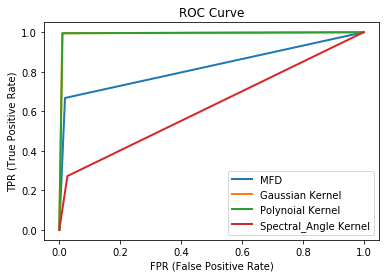

In [22]:
def prepare_label_vector(arr_):
    y = []
    for i in range(arr_.shape[0]):
        for j in range(arr_.shape[1]):
            if np.sum(arr_[i, j, :]) == 0: # black pixels have lable 0
                y.append(0)
            else:
                y.append(1) # white pixels have label 1
    y = np.array(y).reshape(-1,1)
    return y

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
#     plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    
    
y_GROUND_TRUTH   = prepare_label_vector(GT_RGB)
y_MFD            = prepare_label_vector(predictions_MFD)
y_gaussian       = prepare_label_vector(predictions_gaussian)
y_poly           = prepare_label_vector(predictions_poly)
y_spectral_angle = prepare_label_vector(predictions_spectral_angle)

# using sklearn's roc_curve method to get FPR, TPR & Thresholds for each
fpr_MFD, tpr_MFD, _                       = roc_curve(y_GROUND_TRUTH, y_MFD)
fpr_gaussian, tpr_gaussian, _             = roc_curve(y_GROUND_TRUTH, y_gaussian)
fpr_poly, tpr_poly, _                     = roc_curve(y_GROUND_TRUTH, y_poly)
fpr_spectral_angle, tpr_spectral_angle,_  = roc_curve(y_GROUND_TRUTH, y_spectral_angle)


plot_roc_curve(fpr_MFD, tpr_MFD, label="MFD")
plot_roc_curve(fpr_gaussian, tpr_gaussian, label="Gaussian Kernel")
plot_roc_curve(fpr_poly, tpr_poly, label="Polynoial Kernel")
plot_roc_curve(fpr_spectral_angle, tpr_spectral_angle, label="Spectral_Angle Kernel")
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend()
plt.title("ROC Curve")
plt.savefig("./pics/ROC.png")